# Raman Spectra Quality Control

## Setup

Import required packages

In [7]:
import os

from raman_lib.spectra_scoring import score_sort_spectra
from raman_lib.misc import load_data
from raman_lib.visualization import plot_spectra_peaks

Settings

In [8]:
# Name of the Dataset (for the output file)
name = "Biofilme"

# Path where the data is stored
path = r"./data"

# QC settings - Choose either A or B and set the other to 'None'
# A)
n = None # How many spectra (per class) to keep (exactly this number - or less 
         # if a class does not contain enough spectra)
         
# B)
score_min = 5000 # Minimum quality score that a spectrum must have to be kept.
n_min = 10 # Number of spectra that will be kept per class regardless of the score

# Window size for the Savitzky-Golay-Filter. Higher means stronger smoothing and less peaks found
sg_window = 15

# Threshold for the second derivative. Higher means less peaks found.
threshold = 0.5

## Load Data

In [9]:
data = load_data(path)

print("Number of spectra per class:")
print(data.label.value_counts())

Number of spectra per class:
1B      48
W       32
W+2B    16
2B      16
PW      15
W+1B    15
Name: label, dtype: int64


## Scoring and Spectra Selection

In [10]:


data_new, score_dict = score_sort_spectra(data, 
                                          n=n,
                                          min_score=score_min, 
                                          min_n=n_min, 
                                          sg_window=sg_window, 
                                          threshold=threshold, 
                                          detailed=True)

print()
print("====================================")
print()
print("Number of spectra per class (after QC):")
print(data_new.label.value_counts())

Analyzed 142 spectra in 5.91 seconds.

Mean Score: 25605

1st Quartile: 12220
Median Score: 17541
3rd Quartile: 32775

Min Score: 367
Max Score: 72732


Number of spectra per class (after QC):
1B      48
W       32
W+2B    16
W+1B    15
2B      10
PW      10
Name: label, dtype: int64


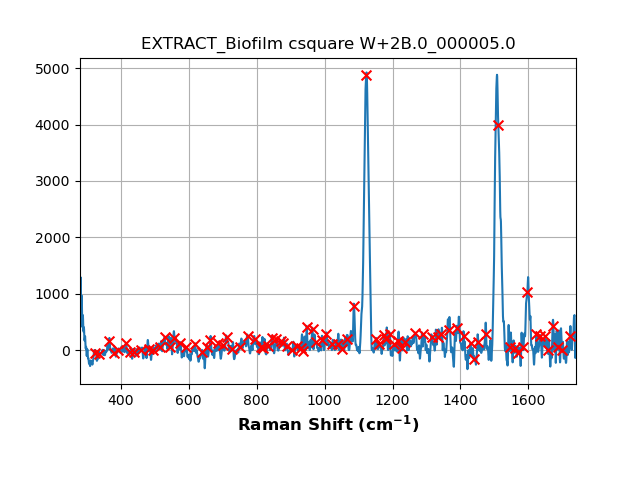

In [11]:
%matplotlib widget
plot_spectra_peaks(data.drop(columns=["label", "file"]).columns, 
                   data.drop(columns=["label", "file"]).values, 
                   score_dict["peak_pos"],
                   labels=data.file)

## Export selected spectra

In [12]:
filename = name.lower().replace(" ", "_") + ".csv"

if not os.path.exists("./results_qc/"):
    os.mkdir("./results_qc/")

data_new.to_csv(os.path.join("./results_qc/", filename), index=False)